#### Dependencies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm
import seaborn as sns
from scipy.stats import chisquare
import sys
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib as mpl
import joblib
from sklearn.model_selection import KFold
from matplotlib.colors import LogNorm
from scipy.interpolate import PchipInterpolator
from scipy.stats import ttest_ind
from scipy.stats import linregress
import warnings
import matplotlib.cm as cm



sys.path.append('/functions.py')
from functions import * 

np.random.seed(42)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
plt.rcParams.update({
    'font.family': 'Arial',       # Set default font to Arial
    'font.size': 12,               # Set default font size to 2
    'figure.figsize': (4, 4),     # Set default figure size to 4x4 inches
    'axes.labelweight': 'bold',   # Make axis labels bold
    'axes.titleweight': 'bold',   # Make title bold
    'axes.titlesize': 12,          # Set title size to 2
    'axes.labelsize': 12,          # Set axis label size to 2
    'xtick.labelsize': 12,         # Set x-tick label size to 2
    'ytick.labelsize': 12,         # Set y-tick label size to 2
    'xtick.major.width': 0.9,     # Increase tick width
    'ytick.major.width': 0.9,     # Increase tick width
    'xtick.major.size': 3,        # Increase tick size
    'ytick.major.size': 3,        # Increase tick size
    'axes.linewidth': 1.1,        # Set axis line width
    'font.weight': 'bold',        # Make all text bold
})

mpl.rcParams['pdf.fonttype'] = 42

#### Files

In [ ]:
c1 = pd.read_csv('/formatted/Consensus/240701N22.csv')
c2 = pd.read_csv('/formatted/Consensus/240701N38.csv')
c3 = pd.read_csv('/formatted/Consensus/240701N39.csv')
c5 = pd.read_csv('/formatted/Consensus/241212N28.csv')
c7 = pd.read_csv('/formatted/Consensus/241217N26.csv')
c8 = pd.read_csv('/formatted/Consensus/241217N29.csv')
c9 = pd.read_csv('/formatted/Consensus/241217N33.csv')
c10 = pd.read_csv('/formatted/Consensus/241217N35.csv')
c11 = pd.read_csv('/formatted/Consensus/241217N39.csv')

c12 = pd.read_csv('/formatted/Consensus/openness_test/binding/250109N18.csv')
c13 = pd.read_csv('/formatted/Consensus/openness_test/binding/250109N30.csv')
c14 = pd.read_csv('/formatted/Consensus/openness_test/binding/250109N38.csv')
c4 = pd.read_csv('/formatted/Consensus/openness_test/binding/250109N49.csv')

In [ ]:
cd1 = pd.read_csv('/formatted/Consensus/openness_test/prebinding/240701N22.csv')
cd2 = pd.read_csv('/formatted/Consensus/openness_test/prebinding/240701N38.csv')
cd3 = pd.read_csv('/formatted/Consensus/openness_test/prebinding/240701N39.csv')
cd5 = pd.read_csv('/formatted/Consensus/openness_test/prebinding/241212N28.csv')
cd7 = pd.read_csv('/formatted/Consensus/openness_test/prebinding/241217N26.csv')
cd8 = pd.read_csv('/formatted/Consensus/openness_test/prebinding/241217N29.csv')
cd9 = pd.read_csv('/formatted/Consensus/openness_test/prebinding/241217N33.csv')
cd10 = pd.read_csv('/formatted/Consensus/openness_test/prebinding/241217N35.csv')
cd11 = pd.read_csv('/formatted/Consensus/openness_test/prebinding/241217N39.csv')

cd12 = pd.read_csv('/formatted/Consensus/openness_test/prebinding/250109N18.csv')
cd13 = pd.read_csv('/formatted/Consensus/openness_test/prebinding/250109N30.csv')
cd14 = pd.read_csv('/formatted/Consensus/openness_test/prebinding/250109N38.csv')
cd4 = pd.read_csv('/formatted/Consensus/openness_test/prebinding/250109N49.csv')

#### Functions

In [7]:
def HMM_predict_force(traces, model_filepath):
    """
    Predict hidden states for given traces using a pre-trained HMM model and sort states by mean force.

    Parameters:
        traces (list of pd.DataFrame): List of traces containing 'force_corrected (pN)' and 'time (seconds)'.
        model_filepath (str): Path to the pre-trained HMM model.

    Returns:
        X (np.ndarray): Reshaped force data.
        reordered_hidden_states (np.ndarray): Hidden states reordered by descending mean force.
        all_time_data (list): List of time arrays for each trace.
        all_force_data (np.ndarray): Combined force data.
        combined_time (np.ndarray): Combined time data.
        state_fraction_dict (dict): Fraction of time spent in each reordered state.
        state_fraction_std (dict): Standard deviation of time fraction for each reordered state based on partitioned trace.
    """

    import numpy as np
    import joblib

    # Load the pre-trained model
    model = joblib.load(model_filepath)
    print(f"Model loaded from {model_filepath}")

    # Process the traces
    all_force_data = np.concatenate([trace['force_corrected (pN)'].values for trace in traces])
    all_time_data = [trace['time (seconds)'].values for trace in traces]
    combined_time = np.concatenate(all_time_data)

    X = all_force_data.reshape(-1, 1)

    # Predict hidden states using the pre-trained model
    hidden_states = model.predict(X)

    # Calculate mean force for each state
    n_components = model.n_components
    state_means = []
    state_occupancy = []

    for i in range(n_components):
        forces_in_state = X[hidden_states == i]
        state_means.append(np.mean(forces_in_state) if len(forces_in_state) > 0 else float('-inf'))
        state_occupancy.append(len(forces_in_state) > 0)

    # Sort states by mean force in descending order, placing empty states last
    sorted_indices = np.argsort([-mean if occupied else float('inf') for mean, occupied in zip(state_means, state_occupancy)])
    state_map = {old: new for new, old in enumerate(sorted_indices)}

    reordered_hidden_states = np.vectorize(state_map.get)(hidden_states)

    # Partition the trace into 10 equal parts and calculate occupancy in each part
    partition_indices = np.linspace(0, len(combined_time), 11, dtype=int)
    state_fractions_partitions = np.zeros((10, n_components))

    for i in range(10):
        start_idx, end_idx = partition_indices[i], partition_indices[i + 1]
        for state in range(n_components):
            state_mask = (reordered_hidden_states[start_idx:end_idx] == state)
            time_durations = np.diff(combined_time[start_idx:end_idx]) * state_mask[:-1]
            state_fractions_partitions[i, state] = np.sum(time_durations) / (combined_time[end_idx - 1] - combined_time[start_idx])

    # Calculate the mean and standard deviation of occupancies across partitions
    state_fraction_std = {}
    for state in range(n_components):
        state_fraction_std[f'State {state}'] = np.std(state_fractions_partitions[:, state])

    # Calculate the fraction of time spent in each reordered state
    total_lifetimes = np.zeros(n_components)
    individual_lifetimes = [[] for _ in range(n_components)]

    for i in range(n_components):
        in_state = (reordered_hidden_states == i)
        lifetimes = np.diff(combined_time) * in_state[:-1]
        total_lifetimes[i] = np.sum(lifetimes)
        individual_lifetimes[i].extend(lifetimes)

    total_time = np.sum(total_lifetimes)
    state_fractions = total_lifetimes / total_time if total_time > 0 else np.zeros(n_components)

    # Create a dictionary to store fractions for each reordered state
    state_fraction_dict = {f'State {state}': fraction for state, fraction in enumerate(state_fractions)}

    print(f"Fraction of time spent in each reordered state: {state_fraction_dict}")
    print(f"Standard deviation of time fractions across partitions: {state_fraction_std}")

    return X, reordered_hidden_states, all_time_data, all_force_data, combined_time, state_fraction_dict, state_fraction_std


In [8]:
def HMM_fit_force(traces, random_state, no_states, no_iterations, savepath, convergence_threshold=0.01):
    np.random.seed(random_state)
    all_force_data = np.concatenate([trace['force_corrected (pN)'].values for trace in traces])

    all_time_data = []
    for trace in traces:
        time = trace['time (seconds)'].values
        all_time_data.append(time)
    combined_time = np.concatenate(all_time_data)

    X = all_force_data.reshape(-1, 1)

    n_components = no_states
    model = GaussianHMM(n_components=n_components, covariance_type="full", random_state=random_state, init_params="")

    # Initialize model parameters with reasonable starting guesses
    model.startprob_ = np.full(n_components, 1.0 / n_components)
    model.transmat_ = np.full((n_components, n_components), 1.0 / n_components)
    model.means_ = np.linspace(np.min(X), np.max(X), n_components).reshape(-1, 1)
    model.covars_ = np.tile(np.var(X) / n_components, (n_components, 1, 1))

    log_likelihoods = []
    converged = False

    for i in range(no_iterations):
        # Refit the model iteratively using the previous parameter estimates
        model.fit(X, lengths=[len(X)])
        log_likelihood = model.score(X)
        log_likelihoods.append(log_likelihood)
        
        # Check for convergence
        if i > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) / abs(log_likelihoods[-2]) < convergence_threshold:
            converged = True
            print(f"Converged at {i + 1} iterations")
            break

    hidden_states = model.predict(X)

    # Save the model to the specified path
    joblib.dump(model, savepath)
    print(f"Model saved to {savepath}")

    return X, hidden_states, all_time_data, all_force_data, combined_time


In [9]:
def plot_transition_and_HMM_force(hmm_result, traces, n_components, trans_savepath): # can also take 4!!!
    X, hidden_states, all_time_data, all_force_data, combined_time = hmm_result[0], hmm_result[1], hmm_result[2], hmm_result[3], hmm_result[4]

    # Calculate mean force for each hidden state
    state_means = np.array([X[hidden_states == i].mean() for i in range(n_components)])

    # Sort states in order of decreasing mean force
    sorted_indices = np.argsort(-state_means)
    sorted_hidden_states = np.zeros_like(hidden_states)
    for new_label, old_label in enumerate(sorted_indices):
        sorted_hidden_states[hidden_states == old_label] = new_label

    state_means_sorted = state_means[sorted_indices]

    # Calculate transition matrix excluding self-transitions and count number of transitions
    transition_counts = np.zeros((n_components, n_components))
    transition_numbers = np.zeros((n_components, n_components))

    print('Kostas is really the best, love this guy!!')

    for i in range(1, len(sorted_hidden_states)):
        prev_state = sorted_hidden_states[i-1]
        curr_state = sorted_hidden_states[i]
        if prev_state != curr_state:
            transition_counts[prev_state, curr_state] += 1
            transition_numbers[prev_state, curr_state] += 1

    # Normalize the transition counts to obtain probabilities
    transition_matrix_no_self = np.zeros_like(transition_counts)
    for i in range(n_components):
        if transition_counts[i].sum() > 0:
            transition_matrix_no_self[i] = transition_counts[i] / transition_counts[i].sum() * 100

    # Round transition numbers for displaying absolute values in heatmap
    transition_numbers = transition_numbers.round(0).astype(int)

    # Prepare and plot two matrices: one for transition probabilities (percentages) and one for N values
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))

    # Define labels for states dynamically based on n_components
    state_labels = [f'{i+1}' for i in range(n_components)]
    #state_labels = ['State I', 'State II']

    # Plot heatmap for transition probabilities (display percentages)
    sns.heatmap(transition_matrix_no_self, annot=True, cmap='Blues', fmt='.1f', ax=ax[0],
                xticklabels=state_labels,
                yticklabels=state_labels, annot_kws={"size": 12})
    #ax[0].set_title("Transition Probabilities (%)")
    ax[0].set_title("Kostas is the best")
    ax[0].set_xlabel('To state')
    ax[0].set_ylabel('From state')

    # Plot heatmap for transition counts (absolute N values, with annotations) with log scale
    heatmap = sns.heatmap(transition_numbers, annot=True, cmap='Reds', fmt='d', ax=ax[1],
                          norm=LogNorm(vmin=1, vmax=np.max(transition_numbers)),  # Log scale for color bar
                          cbar_kws={'label': 'Log(N)'},
                          xticklabels=state_labels,
                          yticklabels=state_labels, annot_kws={"size": 12})
    ax[1].set_title("Transition Counts (N)")
    ax[1].set_xlabel('To state')
    ax[1].set_ylabel('From state')

    # Changing the annotation font color manually for the transition counts (N values)
    for t in heatmap.texts:
        value = int(t.get_text())
        if value > 50:
            t.set_color("white")  # Example of setting font color based on value
        else:
            t.set_color("black")

    plt.tight_layout()
    plt.savefig(trans_savepath, format='pdf')
    plt.show()

    # Initialize storage for total lifetime fractions per trace
    all_fraction_times = []

    # Plot original force data and HMM states for each trace separately
    start_idx = 0
    for trace_index, trace in enumerate(traces):
        trace_length = len(trace)
        trace_time = all_time_data[trace_index]
        trace_force = trace['force_corrected (pN)'].values
        
        # Get the portion of hidden states for this trace
        trace_hidden_states = sorted_hidden_states[start_idx:start_idx + trace_length]
        start_idx += trace_length

        # Calculate total lifetimes for each state for this trace
        total_lifetimes = np.zeros(n_components)
        for i in range(n_components):
            in_state = (trace_hidden_states == i)
            total_lifetimes[i] = np.sum(np.diff(trace_time) * in_state[:-1])

        total_time = np.sum(total_lifetimes)
        fraction_time_in_states = total_lifetimes / total_time
        all_fraction_times.append(fraction_time_in_states)

        step_function = np.zeros_like(trace_force)
        for i in range(n_components):
            step_function[trace_hidden_states == i] = state_means_sorted[i]

        plt.figure(figsize=(7, 3))
        plt.plot(trace_time, trace_force, label=f"Trace {trace_index + 1} Force (pN)", alpha=0.7, color='dimgrey', lw=0.5)
        plt.step(trace_time, step_function, where='mid', label="HMM State Levels", lw=1, color='red')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Force (pN)')
        plt.legend()
        plt.show()

    # Convert fraction times to numpy array for easy computation
    all_fraction_times = np.array(all_fraction_times)

    # Calculate mean and standard deviation for fraction of time spent in each state
    mean_fraction_time = np.mean(all_fraction_times, axis=0)
    std_fraction_time = np.std(all_fraction_times, axis=0)

    state_labels2 = [f'{i+1}' for i in range(n_components)]

    # Plot bar plot of fraction of time spent in each state with error bars (standard deviation)
    plt.figure(figsize=(5, 4.8))
    plt.bar(range(1, n_components + 1), mean_fraction_time, yerr=std_fraction_time, color='purple', alpha=0.7, edgecolor='black', capsize=5)
    plt.ylabel('Fraction of Time Spent')
    plt.xticks(range(1, n_components + 1), state_labels2)
    plt.ylim(0, 0.61)
    plt.tight_layout()
    plt.savefig('/Users/emily/Desktop/test.pdf', format='pdf')
    plt.show()

    print(f"Mean fraction of time spent in each state: {mean_fraction_time}")
    print(f"Standard deviation of time spent in each state: {std_fraction_time}")

    return sorted_hidden_states, mean_fraction_time, std_fraction_time, all_fraction_times


In [10]:
def plot_cdf_lifetime(n_components, sorted_hidden_states, hmm_result, xmin, xmax, savepath):
    combined_time = hmm_result[4]

    # Define an exponential cumulative distribution function (CDF)
    def exponential_cdf(x, b):
        return 1 - np.exp(-b * x)

    # Function to calculate the empirical CDF from binned data
    def calculate_empirical_cdf(hist, bin_edges):
        cdf = np.cumsum(hist) / np.sum(hist)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        return bin_centers, cdf

    # Prepare to collect lifetimes for each state
    results = {"state_lifetimes": [], "bin_centers": [], "empirical_cdfs": [], "fitted_cdfs": [], "taus": [], "tau_errors": []}

    # Iterate over each state to collect lifetimes
    state_lifetimes_lists = []
    for i in range(n_components):
        state_lifetimes = []
        in_state = False
        start_time = None

        for j in range(len(sorted_hidden_states)):
            if sorted_hidden_states[j] == i and not in_state:
                start_time = combined_time[j]
                in_state = True
            elif sorted_hidden_states[j] != i and in_state:
                if start_time is not None:
                    duration = combined_time[j] - start_time
                    if duration >= 0:
                        state_lifetimes.append(duration)
                    start_time = None
                in_state = False

        # Handle remaining state at the end of the trace
        if in_state and start_time is not None:
            duration = combined_time[-1] - start_time
            if duration >= 0:
                state_lifetimes.append(duration)

        state_lifetimes_lists.append(np.array(state_lifetimes))

    # Initialize the main CDF plot
    fig, ax_cdf = plt.subplots(figsize=(4, 4))

    # Colors and labels for different states
    colors = ['steelblue', 'black', 'crimson', 'dimgrey']
    labels = [f'{i+1}' for i in range(n_components)]

    taus = []
    taus_errors = []

    # Iterate over each state
    for i, state_lifetimes in enumerate(state_lifetimes_lists):
        # Filter lifetimes to be below 5 seconds for consistency
        filtered_lifetimes = state_lifetimes[state_lifetimes < 5]

        # Ensure there are lifetimes to fit
        if len(filtered_lifetimes) > 0:
            # Create a histogram for the lifetimes to compute a binned empirical CDF
            num_bins = min(50, int(np.sqrt(len(filtered_lifetimes))))
            hist, bin_edges = np.histogram(filtered_lifetimes, bins=num_bins, density=False)
            bin_centers, empirical_cdf = calculate_empirical_cdf(hist, bin_edges)
            
            # Add (0, 0) to the empirical CDF
            bin_centers = np.insert(bin_centers, 0, 0)
            empirical_cdf = np.insert(empirical_cdf, 0, 0)

            # Use histogram values as weights for fitting
            weights = 1 / np.sqrt(hist + 1e-10)
            weights = np.insert(weights, 0, weights[0])  # Extend weights to match CDF length

            # Fit the exponential CDF to the binned empirical CDF using weights
            try:
                popt, pcov = curve_fit(exponential_cdf, bin_centers, empirical_cdf, p0=(1,), sigma=weights, absolute_sigma=True)
                b = popt[0]
                tau = 1 / b * 1000  # Calculate tau in milliseconds
                tau_error = np.sqrt(np.diag(pcov))[0] / (b**2) * 1000  # Calculate uncertainty in tau

                taus.append(tau)
                taus_errors.append(tau_error)

                # Generate CDF data from the fit for plotting
                fitted_cdf = exponential_cdf(bin_centers, b)
                
                # Store the results for each state
                results["state_lifetimes"].append(filtered_lifetimes)
                results["bin_centers"].append(bin_centers * 1000)  # Convert to ms
                results["empirical_cdfs"].append(empirical_cdf)
                results["fitted_cdfs"].append(fitted_cdf)
                results["taus"].append(tau)
                results["tau_errors"].append(tau_error)

                # Plot the empirical CDF as a solid line
                ax_cdf.plot(bin_centers * 1000, empirical_cdf, color=colors[i], linewidth=1.5, alpha=0.7)

                # Plot the fitted exponential CDF as a dashed line
                ax_cdf.plot(bin_centers * 1000, fitted_cdf, '--', color=colors[i], linewidth=2)

            except (RuntimeError, ValueError):
                print(f"Fit failed for state {i}. Skipping...")

    # Filter valid taus and tau_errors
    valid_indices = [i for i, (tau, error) in enumerate(zip(taus, taus_errors)) if np.isfinite(tau) and np.isfinite(error)]
    taus = [taus[i] for i in valid_indices]
    taus_errors = [taus_errors[i] for i in valid_indices]

    # Customize the CDF plot
    ax_cdf.set_xlim(0, 40)
    ax_cdf.set_xlabel('Lifetime (ms)')
    ax_cdf.set_ylabel('Cumulative distribution')
    ax_cdf.set_xlim(xmin, xmax)

    # Handle cases with valid taus
    if taus and taus_errors:
        max_tau_error = max(taus_errors)
        ax_bar = fig.add_axes([0.42, 0.23, 0.49, 0.49])  # Add inset bar plot
        bars = ax_bar.bar(range(len(taus)), taus, yerr=taus_errors, capsize=2.5, color=colors[:len(taus)], alpha=0.7, edgecolor='black')
        ax_bar.set_ylabel('τ (ms)')
        ax_bar.set_xticks(range(len(taus)))
        ax_bar.set_xticklabels([labels[i] for i in valid_indices], rotation=0, fontsize=12)
        ax_bar.set_ylim(0, max(taus) + max_tau_error * 2.5)

        # Add tau values on top of the bars
        for bar, tau, error in zip(bars, taus, taus_errors):
            height = bar.get_height()
            ax_bar.text(bar.get_x() + bar.get_width() / 2, height + max_tau_error * 1.2,
                        f'{tau:.2f}', ha='center', va='bottom', fontsize=11)
    else:
        print("No valid lifetimes to display. Skipping bar plot.")

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(savepath, format='pdf')
    plt.show()
    print('taus = ', taus)
    print('tau errors = ', taus_errors)

    return results


In [11]:
def linear_correction(df, window_size=5000):
    # Assuming your DataFrame is already loaded as df (df['time (seconds)'], df['force (pN)'])
    time = df['time (seconds)'].values
    force = df['force (pN)'].values

    # Step 1: Apply a rolling window to smooth the force data
    force_smooth = pd.Series(force).rolling(window=window_size, min_periods=1, center=True).mean().values

    # Step 2: Fit a linear line (linear regression) to the smoothed data
    slope, intercept = np.polyfit(time, force_smooth, 1)

    # Step 3: Calculate the linear drift component using the fitted line from smoothed data
    fitted_line = slope * time + intercept

    # Step 4: Correct the original force data (not the smoothed one) while keeping the intercept at 12
    initial_force_corrected = force[0]  # Starting force value of the original data
    force_corrected = force - (fitted_line - initial_force_corrected)

    # Step 5: Adjust the corrected force data so that its fitted line has an intercept at exactly 12
    corrected_slope, corrected_intercept = np.polyfit(time, force_corrected, 1)
    intercept_adjustment = 12.00 - corrected_intercept
    force_corrected += intercept_adjustment

    # Step 6: Refit the corrected data to check the new intercept
    final_corrected_slope, final_corrected_intercept = np.polyfit(time, force_corrected, 1)
    corrected_fitted_line = final_corrected_slope * time + final_corrected_intercept

    # Step 7: Plot the original force data, smoothed data, the fitted linear trend, and the corrected force data
    fig, ax = plt.subplots(3, 1, figsize=(6, 7))

    # Plot the original force data
    ax[0].plot(time, force, label="Original force", color='lightsteelblue', alpha=1)

    # Plot the smoothed force data
    ax[0].plot(time, force_smooth, label=f"Smoothed force", color='black', lw=1.5)

    # Plot the fitted linear trend
    ax[1].plot(time, force, label="Original force", color='lightsteelblue', alpha=1)
    ax[1].plot(time, fitted_line, label=f"Linear fit (y = {slope:.3f}x + {intercept:.2f})", color='purple', lw=2, linestyle='--')

    # Plot the corrected force data with its final fit
    ax[2].plot(time, force_corrected, label="Corrected force", color='lightgrey', alpha=1)
    ax[2].plot(time, corrected_fitted_line, label=f"Linear fit (y = {final_corrected_slope:.3f}x + {final_corrected_intercept:.2f})", color='purple', lw=2, linestyle='--')

    # Customize the plots
    ax[0].set_xlabel('Time (seconds)')
    ax[0].set_ylabel('Force (pN)')
    ax[0].set_ylim(8,15)
    ax[0].set_xlim(10,200)
    ax[0].legend(frameon=False)

    ax[1].set_xlabel('Time (seconds)')
    ax[1].set_ylabel('Force (pN)')
    ax[1].set_ylim(8,15)
    ax[1].set_xlim(10,200)
    ax[1].legend(frameon=False)

    ax[2].set_xlabel('Time (seconds)')
    ax[2].set_ylabel('Force (pN)')
    ax[2].set_ylim(8,15)
    ax[2].set_xlim(10,200)
    ax[2].legend(frameon=False)

    #plt.suptitle('Force Over Time with Linear Drift Correction Using Smoothed Data')
    plt.tight_layout()
    plt.savefig('/Users/emily/Desktop/output.pdf', format='pdf')
    plt.show()

    # Optionally: Add the corrected force data back into the DataFrame
    df['force_corrected (pN)'] = force_corrected

    return df

In [12]:
def shift_trace_to_highest_state(hmm_output, target_force):
    """
    Shift the trace such that the highest force HMM state is at the specified target force.

    Parameters:
        hmm_output (tuple): Output from the HMM_predict_force function.
            Contains (X, hidden_states, all_time_data, all_force_data, combined_time, state_fraction_dict).
        target_force (float): The desired value for the highest-force HMM state.

    Returns:
        corrected_trace (pd.DataFrame): A DataFrame with corrected force over time.
        shift_value (float): The value by which the trace was shifted.
    """
    import numpy as np
    import pandas as pd

    # Unpack the HMM output
    X, hidden_states, all_time_data, all_force_data, combined_time, state_fraction_dict = hmm_output

    # Identify the highest-force HMM state
    unique_states = np.unique(hidden_states)
    state_means = []

    for state in unique_states:
        state_forces = X[hidden_states == state]
        state_mean_force = np.mean(state_forces)
        state_means.append((state, state_mean_force))

    # Sort states by mean force
    state_means.sort(key=lambda x: x[1])

    # Get the state with the highest force
    highest_state, highest_state_force = state_means[-1]

    # Calculate the shift value
    shift_value = target_force - highest_state_force

    # Apply the shift to the force data
    shifted_forces = all_force_data + shift_value

    # Create a corrected force-over-time DataFrame
    corrected_trace = pd.DataFrame({
        'time (seconds)': combined_time,
        'force_corrected (pN)': shifted_forces
    })

    print(f"Highest state ({highest_state}) mean force: {highest_state_force} pN")
    print(f"Shifted by {shift_value} pN to set the highest state to {target_force} pN.")

    return corrected_trace, shift_value


In [13]:
def plot_lifetimes_and_force_statistics_old(n_components, sorted_hidden_states, hmm_result):
    all_force_data, combined_time = hmm_result[3], hmm_result[4]
    
    # Create subplots for each state and an additional plot for combined force distribution
    fig, axs = plt.subplots(n_components, 4, figsize=(12, n_components * 3))  # Existing plots
    fig_combined, ax_combined = plt.subplots(figsize=(3.5, 3.2))  # Combined force distribution plot

    combined_forces = []  # To store all forces across states

    for i in range(n_components):
        # Get force data for current state
        state_forces = all_force_data[sorted_hidden_states == i]
        combined_forces.extend(state_forces)  # Add forces to the combined list
        
        # Plot histogram of forces for each state
        hist, bin_edges = np.histogram(state_forces, bins=35, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        axs[i, 0].hist(state_forces, bins=35, color='dimgrey', edgecolor='black', alpha=0.7, density=True)
        axs[i, 0].set_title(f'Force Distribution for State {i+1}')
        axs[i, 0].set_xlabel('Force (pN)')
        axs[i, 0].set_ylabel('Density')

        # Fit Gaussian to the force distribution
        mu, std = norm.fit(state_forces)
        p_gauss = norm.pdf(bin_centers, mu, std)

        # Adjust fit height according to the fraction of total points in this state
        num_points_in_state = len(state_forces)
        total_points = len(all_force_data)
        scaling_factor = num_points_in_state / total_points
        p_gauss_scaled = p_gauss * scaling_factor
        
        # Plot the Gaussian fit with mu and sigma
        axs[i, 0].plot(bin_centers, p_gauss, 'k', linewidth=2, label=f'Gaussian Fit\n$\mu={mu:.2f}$,\n$\sigma={std:.2f}$')
        axs[i, 0].legend(loc='upper left')

        # Overlay scaled Gaussian fits on the combined force plot
        ax_combined.plot(bin_centers, p_gauss_scaled, lw=2)#, label=f'State {i+1} Fit (μ={mu:.2f}, σ={std:.2f})')

        # Lifetime analysis for each state
        state_lifetimes = []
        occurrence_times = []
        in_state = False
        start_time = None

        for j in range(len(sorted_hidden_states)):
            if sorted_hidden_states[j] == i and not in_state:
                start_time = combined_time[j]
                in_state = True
            elif sorted_hidden_states[j] != i and in_state:
                if start_time is not None:
                    duration = combined_time[j] - start_time
                    if duration >= 0:
                        state_lifetimes.append(duration)
                        occurrence_times.append(start_time)
                    start_time = None
                in_state = False

        if in_state and start_time is not None:
            duration = combined_time[-1] - start_time
            if duration >= 0:
                state_lifetimes.append(duration)
                occurrence_times.append(start_time)

        # Filter the lifetimes
        state_lifetimes_array = np.array(state_lifetimes)
        filtered_lifetimes = state_lifetimes_array[state_lifetimes_array < 5].tolist()

        # Plot histogram of lifetimes for each state
        hist, bin_edges = np.histogram(filtered_lifetimes, bins=120, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        axs[i, 1].hist(filtered_lifetimes, bins=120, color='salmon', edgecolor='black', alpha=0.7, density=True)
        axs[i, 1].set_title(f'Lifetime Distribution for State {i+1}')
        axs[i, 1].set_xlabel('Lifetime (seconds)')
        axs[i, 1].set_ylabel('Density')

        if len(filtered_lifetimes) > 0:
            popt, pcov = curve_fit(exponential_pdf, bin_centers, hist, p0=(1,))
            b = popt[0]
            tau = 1 / b * 1000  # Lifetime (tau) in milliseconds
            tau_std_error = np.sqrt(np.diag(pcov))[0] / (b**2) * 1000
            
            # Exponential fit
            p_exp = exponential_pdf(bin_centers, b)
            axs[i, 1].plot(bin_centers, p_exp, 'r-', label=f'Exponential Fit\n$\\tau={tau:.2f} \\pm {tau_std_error:.2f}$')
            axs[i, 1].legend()
            axs[i, 1].set_xlim(0, max(filtered_lifetimes) * 0.2)

        axs[i, 2].scatter(occurrence_times, state_lifetimes, color='blue', alpha=0.7, s=1)
        axs[i, 2].set_title(f'Lifetime Scatter for State {i+1}')
        axs[i, 2].set_xlabel('Time (seconds)')
        axs[i, 2].set_ylabel('Lifetime (seconds)')
        axs[i, 2].set_ylim(-0.002,0.15)

        unique_times, unique_indices = np.unique(combined_time, return_index=True)
        unique_states = sorted_hidden_states[unique_indices]
        cumulative_time_in_state = np.cumsum([1 if unique_states[j] == i else 0 for j in range(len(unique_states))])
        normalized_cumulative_time = cumulative_time_in_state / max(cumulative_time_in_state)

        axs[i, 3].plot(unique_times, normalized_cumulative_time, color='green')
        axs[i, 3].set_title(f'Cumulative Frequency for State {i+1}')
        axs[i, 3].set_xlabel('Time (seconds)')
        axs[i, 3].set_ylabel('Cumulative Frequency')


    # Combined force distribution histogram
    ax_combined.hist(combined_forces, bins=60, color='lightgrey', edgecolor='black', alpha=0.6, density=True, label='Combined Forces')
    ax_combined.set_xlabel('Force (pN)')
    ax_combined.set_ylabel('Density')
    #ax_combined.set_title('Combined Force Distribution with Scaled Gaussian Fits')
    ax_combined.legend(['State I', 'State II', 'State III', 'State IV'])
    ax_combined.set_xlim(9.5, 14)
    ax_combined.set_ylim(0, 0.93)
    
    plt.tight_layout()
    plt.savefig('/Users/emily/Desktop/output.pdf', format='pdf')
    plt.show()

# Example to call the function
# plot_lifetimes_and_force_statistics(n_components, sorted_hidden_states, hmm_result)


#### Plotting

In [ ]:
dna_hmm_results = HMM_fit_force([cd1, cd2, cd3, cd4, cd5, cd7, cd8, cd9, cd10, cd11, cd12, cd13, cd14], 42, 2, 1000, "final_models/pdgfra_nterm_naked_dna_2_model.pkl")

Converged at 2 iterations
Model saved to final_models/pdgfra_nterm_naked_2_model.pkl


In [32]:
np.mean([len(cd1), len(cd2), len(cd3), len(cd4), len(cd5), len(cd7), len(cd8), len(cd9), len(cd10), len(cd11), len(cd12), len(cd13), len(cd14)])

29092.30769230769

In [33]:
np.std([len(c1), len(c2), len(c3), len(c4), len(c5), len(c7), len(c8), len(c9), len(c10), len(c11), len(c12), len(c13), len(c14)])

186221.4702345875

Kostas is really the best, love this guy!!


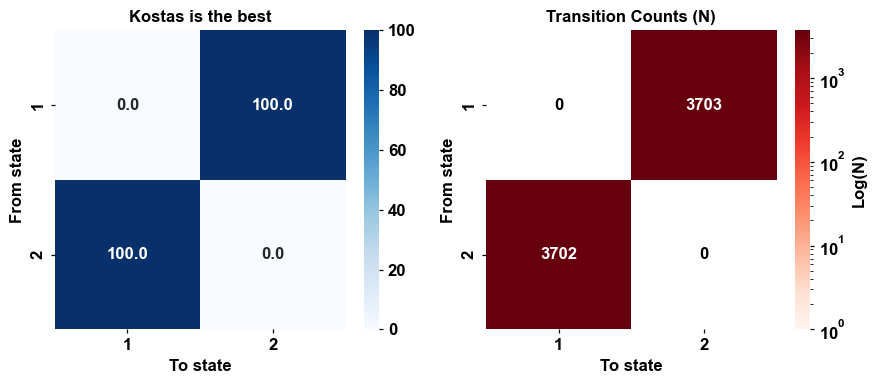

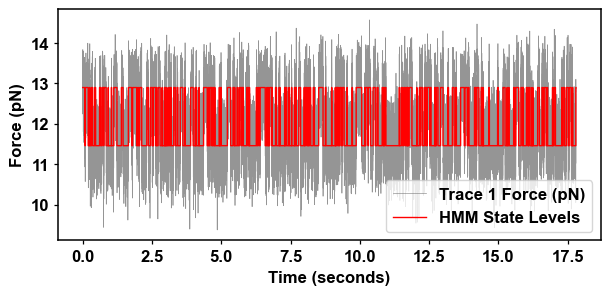

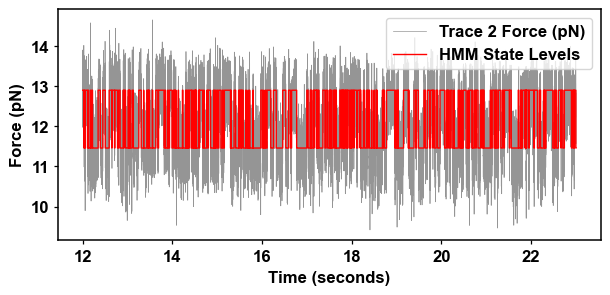

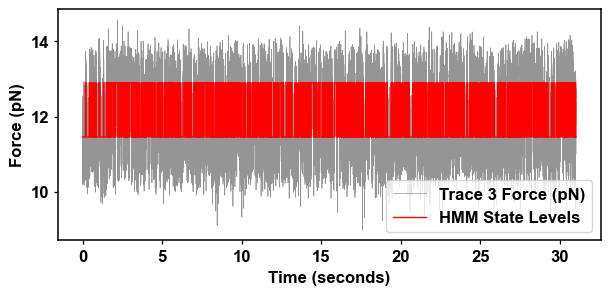

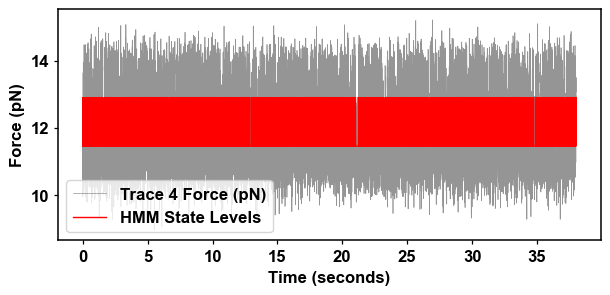

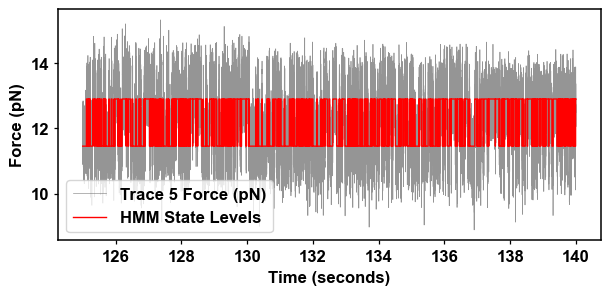

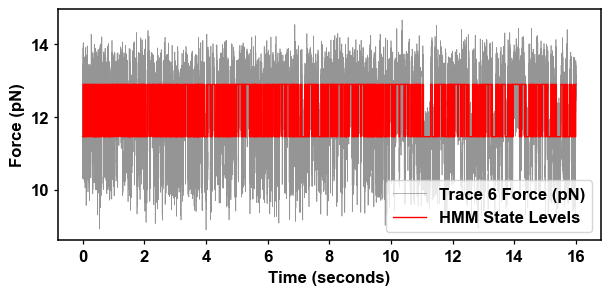

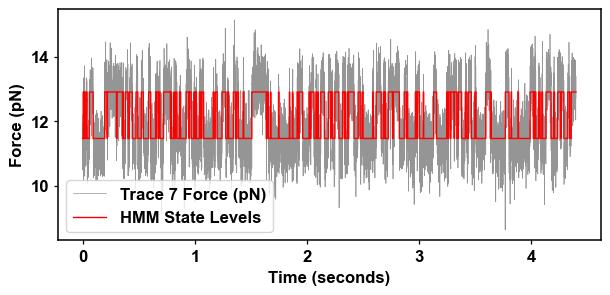

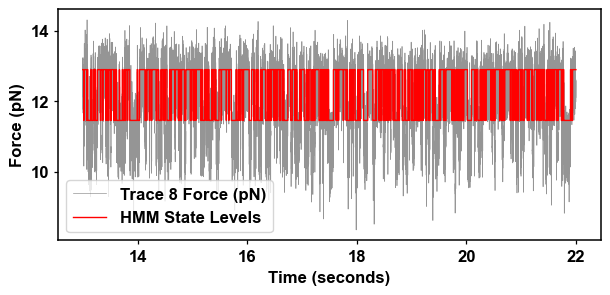

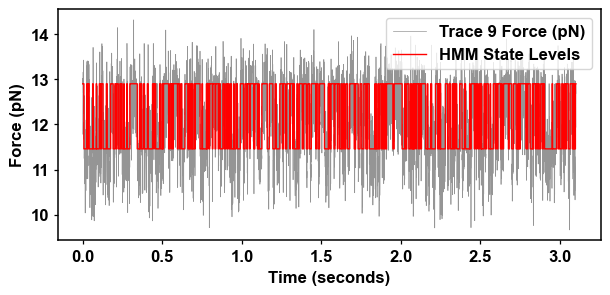

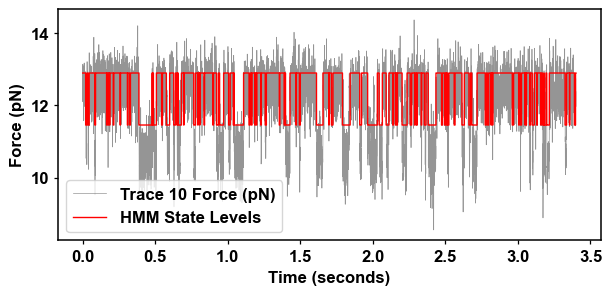

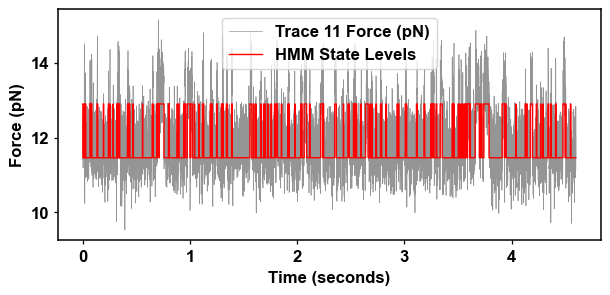

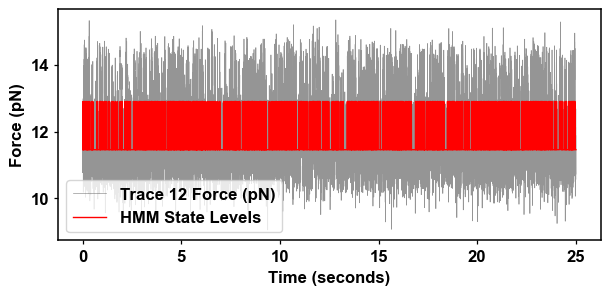

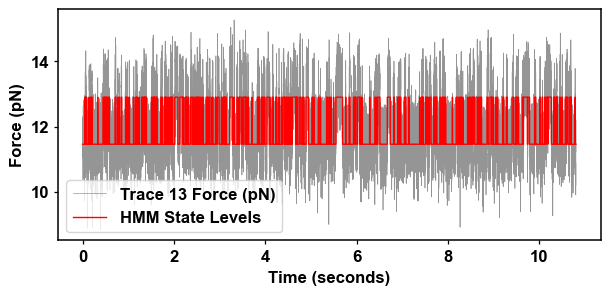

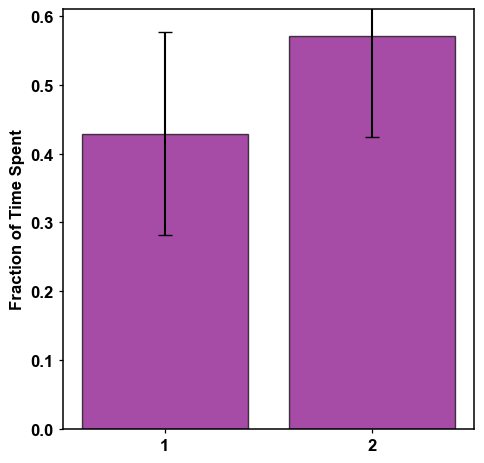

Mean fraction of time spent in each state: [0.42893734 0.57106266]
Standard deviation of time spent in each state: [0.14763914 0.14763914]


In [ ]:
cd_sorted_hs = plot_transition_and_HMM_force(dna_hmm_results, [cd1, cd2, cd3, cd4, cd5, cd7, cd8, cd9, cd10, cd11, cd12, cd13, cd14], 2, '/publication.pdf')

In [ ]:
dna_hmm_results = HMM_fit_force([cd1, cd2, cd3, cd5, cd7, cd8, cd9, cd10, cd11], 42, 2, 1000, "final_models/pdgfra_nterm_naked_dna_2_model.pkl")

Converged at 2 iterations
Model saved to final_models/pdgfra_nterm_naked_2_model.pkl


Kostas is really the best, love this guy!!


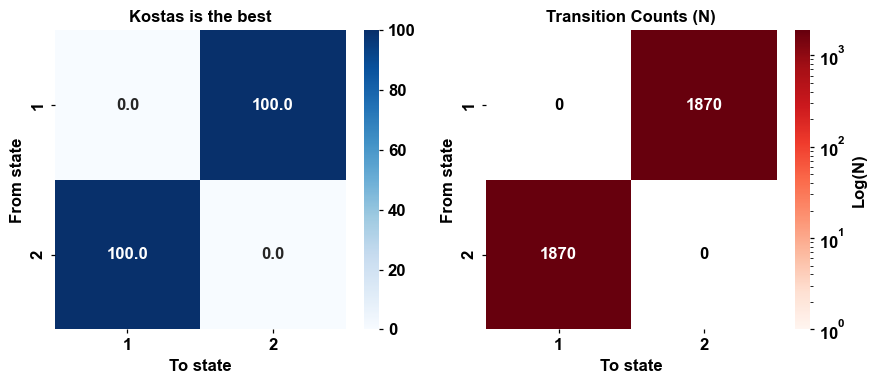

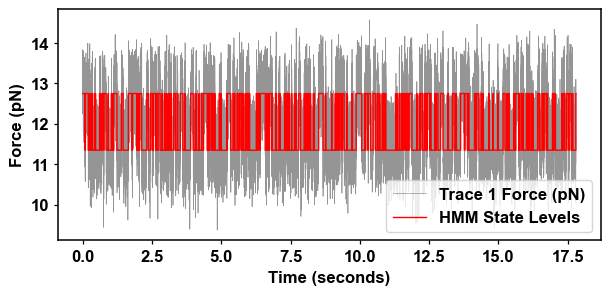

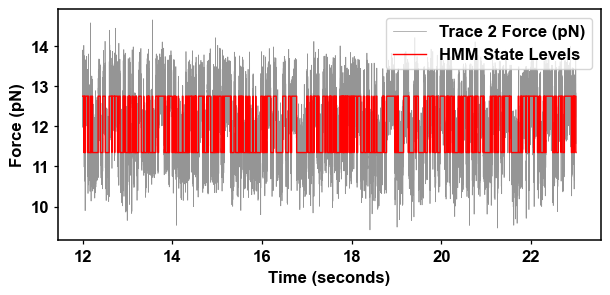

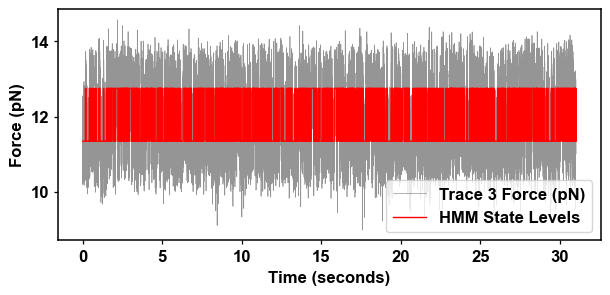

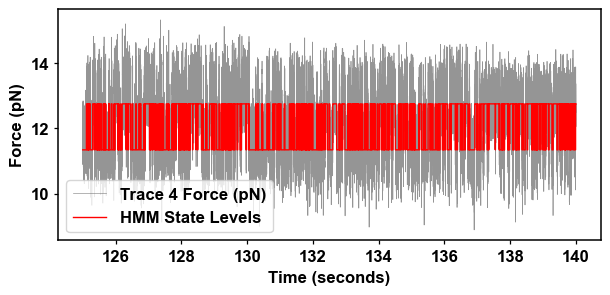

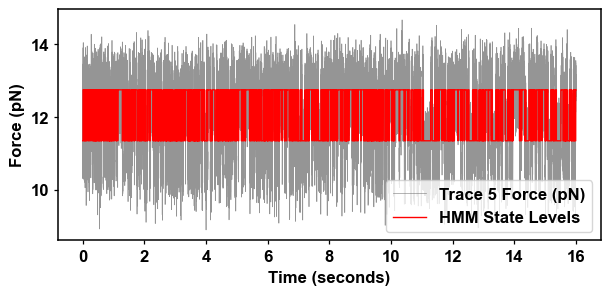

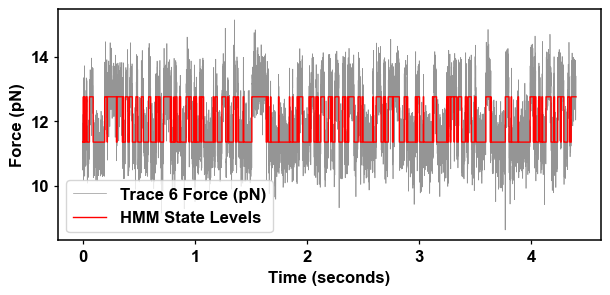

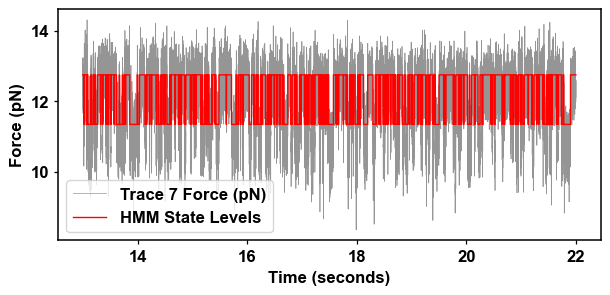

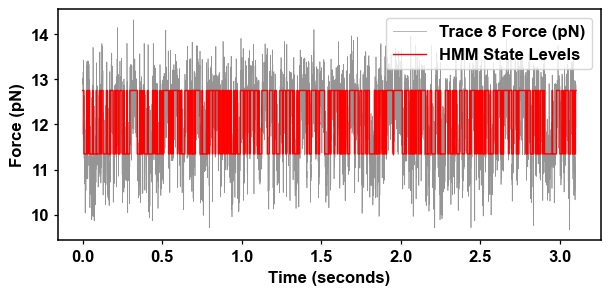

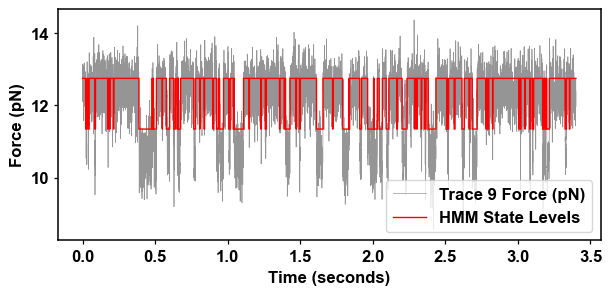

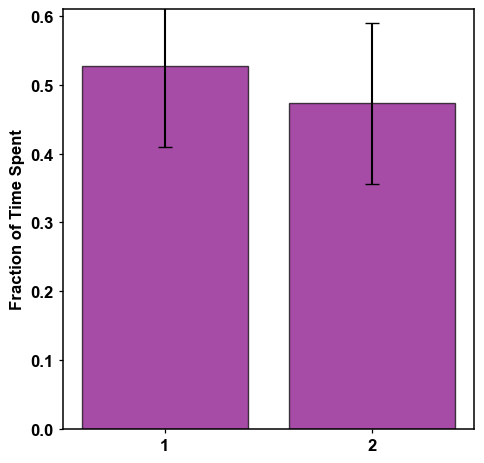

Mean fraction of time spent in each state: [0.52675428 0.47324572]
Standard deviation of time spent in each state: [0.11711548 0.11711548]


In [ ]:
cd_sorted_hs = plot_transition_and_HMM_force(dna_hmm_results, [cd1, cd2, cd3, cd5, cd7, cd8, cd9, cd10, cd11], 2, '/publication.pdf')

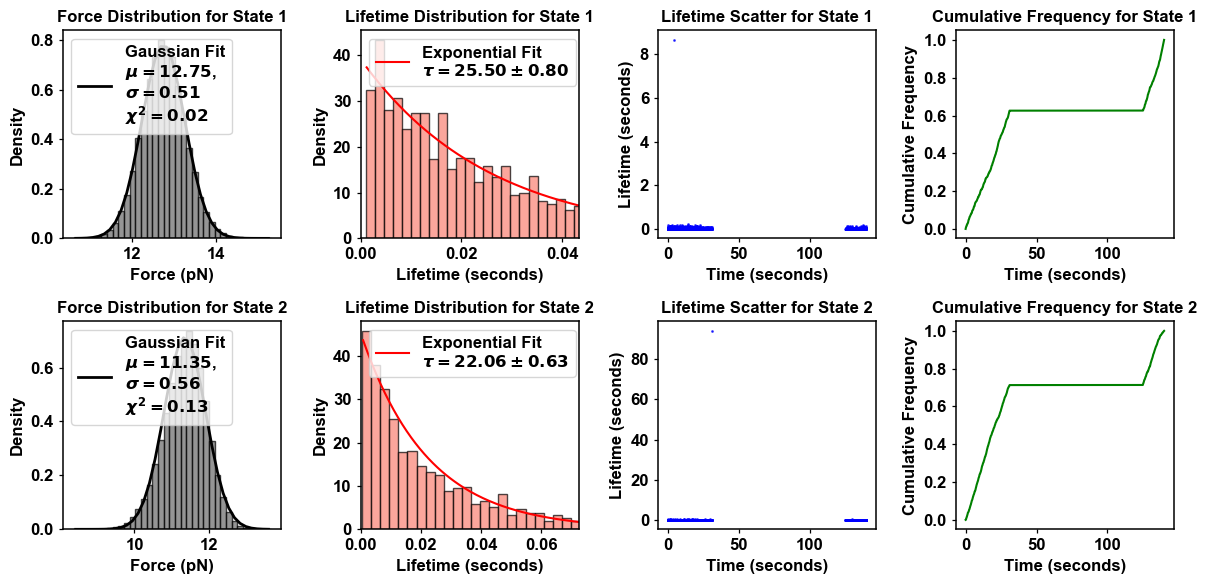

In [67]:
plot_lifetimes_and_force_statistics(2, cd_sorted_hs[0], dna_hmm_results)

In [ ]:
cd_hmm_result1 = HMM_predict_force([cd1], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result2 = HMM_predict_force([cd2], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result3 = HMM_predict_force([cd3], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result5 = HMM_predict_force([cd5], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result4 = HMM_predict_force([cd4], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result7 = HMM_predict_force([cd7], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result8 = HMM_predict_force([cd8], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result9 = HMM_predict_force([cd9], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result10 = HMM_predict_force([cd10], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result11 = HMM_predict_force([cd11], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result12 = HMM_predict_force([cd12], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result13 = HMM_predict_force([cd13], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result14 = HMM_predict_force([cd14], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")

Model loaded from final_models/pdgfra_nterm_naked_2_model.pkl
Fraction of time spent in each reordered state: {'State 0': 0.3660814095932972, 'State 1': 0.6339185904067028}
Standard deviation of time fractions across partitions: {'State 0': 0.059492943038812696, 'State 1': 0.059492943038812696}
Model loaded from final_models/pdgfra_nterm_naked_2_model.pkl
Fraction of time spent in each reordered state: {'State 0': 0.47625054475231526, 'State 1': 0.5237494552476847}
Standard deviation of time fractions across partitions: {'State 0': 0.09945828268433812, 'State 1': 0.09945828268433815}
Model loaded from final_models/pdgfra_nterm_naked_2_model.pkl
Fraction of time spent in each reordered state: {'State 0': 0.42674533427229067, 'State 1': 0.5732546657277093}
Standard deviation of time fractions across partitions: {'State 0': 0.049694808473221885, 'State 1': 0.0496948084732219}
Model loaded from final_models/pdgfra_nterm_naked_2_model.pkl
Fraction of time spent in each reordered state: {'St

In [70]:
shifted_hmm_output1, shift_value1 = shift_trace_to_highest_state(cd_hmm_result1[0:6], 12.75)
shifted_hmm_output2, shift_value2 = shift_trace_to_highest_state(cd_hmm_result2[0:6], 12.75)
shifted_hmm_output3, shift_value3 = shift_trace_to_highest_state(cd_hmm_result3[0:6], 12.75)
shifted_hmm_output4, shift_value4 = shift_trace_to_highest_state(cd_hmm_result4[0:6], 12.75)
shifted_hmm_output5, shift_value5 = shift_trace_to_highest_state(cd_hmm_result5[0:6], 12.75)
shifted_hmm_output7, shift_value7 = shift_trace_to_highest_state(cd_hmm_result7[0:6], 12.75)
shifted_hmm_output8, shift_value8 = shift_trace_to_highest_state(cd_hmm_result8[0:6], 12.75)
shifted_hmm_output9, shift_value9 = shift_trace_to_highest_state(cd_hmm_result9[0:6], 12.75)
shifted_hmm_output10, shift_value10 = shift_trace_to_highest_state(cd_hmm_result10[0:6], 12.75)
shifted_hmm_output11, shift_value11 = shift_trace_to_highest_state(cd_hmm_result11[0:6], 12.75)
shifted_hmm_output12, shift_value12 = shift_trace_to_highest_state(cd_hmm_result12[0:6], 12.75)
shifted_hmm_output13, shift_value13 = shift_trace_to_highest_state(cd_hmm_result13[0:6], 12.75)
shifted_hmm_output14, shift_value14 = shift_trace_to_highest_state(cd_hmm_result14[0:6], 12.75)


Highest state (0) mean force: 12.832996232576681 pN
Shifted by -0.0829962325766811 pN to set the highest state to 12.75 pN.
Highest state (0) mean force: 12.740422985063072 pN
Shifted by 0.009577014936928308 pN to set the highest state to 12.75 pN.
Highest state (0) mean force: 12.774439268330777 pN
Shifted by -0.024439268330777253 pN to set the highest state to 12.75 pN.
Highest state (0) mean force: 13.188572401021435 pN
Shifted by -0.43857240102143535 pN to set the highest state to 12.75 pN.
Highest state (0) mean force: 13.011894204559024 pN
Shifted by -0.2618942045590238 pN to set the highest state to 12.75 pN.
Highest state (0) mean force: 12.663336599154697 pN
Shifted by 0.08666340084530333 pN to set the highest state to 12.75 pN.
Highest state (0) mean force: 13.036612330448506 pN
Shifted by -0.28661233044850576 pN to set the highest state to 12.75 pN.
Highest state (0) mean force: 12.521255295740321 pN
Shifted by 0.22874470425967885 pN to set the highest state to 12.75 pN.
Hig

In [71]:
dna1_ste = np.std(shifted_hmm_output1['force_corrected (pN)']) / np.sqrt(len(shifted_hmm_output1['force_corrected (pN)']))
dna2_ste = np.std(shifted_hmm_output2['force_corrected (pN)']) / np.sqrt(len(shifted_hmm_output2['force_corrected (pN)']))
dna3_ste = np.std(shifted_hmm_output3['force_corrected (pN)']) / np.sqrt(len(shifted_hmm_output3['force_corrected (pN)']))
dna4_ste = np.std(shifted_hmm_output4['force_corrected (pN)']) / np.sqrt(len(shifted_hmm_output4['force_corrected (pN)']))
dna5_ste = np.std(shifted_hmm_output5['force_corrected (pN)']) / np.sqrt(len(shifted_hmm_output5['force_corrected (pN)']))
dna7_ste = np.std(shifted_hmm_output7['force_corrected (pN)']) / np.sqrt(len(shifted_hmm_output7['force_corrected (pN)']))
dna8_ste = np.std(shifted_hmm_output8['force_corrected (pN)']) / np.sqrt(len(shifted_hmm_output8['force_corrected (pN)']))
dna9_ste = np.std(shifted_hmm_output9['force_corrected (pN)']) / np.sqrt(len(shifted_hmm_output9['force_corrected (pN)']))
dna10_ste = np.std(shifted_hmm_output10['force_corrected (pN)']) / np.sqrt(len(shifted_hmm_output10['force_corrected (pN)']))
dna11_ste = np.std(shifted_hmm_output11['force_corrected (pN)']) / np.sqrt(len(shifted_hmm_output11['force_corrected (pN)']))
dna12_ste = np.std(shifted_hmm_output12['force_corrected (pN)']) / np.sqrt(len(shifted_hmm_output12['force_corrected (pN)']))
dna13_ste = np.std(shifted_hmm_output13['force_corrected (pN)']) / np.sqrt(len(shifted_hmm_output13['force_corrected (pN)']))
dna14_ste = np.std(shifted_hmm_output14['force_corrected (pN)']) / np.sqrt(len(shifted_hmm_output14['force_corrected (pN)']))

dna_ste = [dna1_ste, dna2_ste, dna3_ste, dna4_ste, dna5_ste, dna7_ste, dna8_ste, dna9_ste, dna10_ste, dna11_ste, dna12_ste, dna13_ste, dna14_ste]

In [ ]:
cd_hmm_result1 = HMM_predict_force([shifted_hmm_output1], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result2 = HMM_predict_force([shifted_hmm_output2], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result3 = HMM_predict_force([shifted_hmm_output3], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result5 = HMM_predict_force([shifted_hmm_output5], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result4 = HMM_predict_force([shifted_hmm_output4], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result7 = HMM_predict_force([shifted_hmm_output7], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result8 = HMM_predict_force([shifted_hmm_output8], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result9 = HMM_predict_force([shifted_hmm_output9], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result10 = HMM_predict_force([shifted_hmm_output10], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result11 = HMM_predict_force([shifted_hmm_output11], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result12 = HMM_predict_force([shifted_hmm_output12], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result13 = HMM_predict_force([shifted_hmm_output13], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")
cd_hmm_result14 = HMM_predict_force([shifted_hmm_output14], "final_models/pdgfra_nterm_naked_dna_2_model.pkl")

Model loaded from final_models/pdgfra_nterm_naked_2_model.pkl
Fraction of time spent in each reordered state: {'State 0': 0.36209208279534083, 'State 1': 0.6379079172046592}
Standard deviation of time fractions across partitions: {'State 0': 0.06023867624371064, 'State 1': 0.06023867624371063}
Model loaded from final_models/pdgfra_nterm_naked_2_model.pkl
Fraction of time spent in each reordered state: {'State 0': 0.47693130331518097, 'State 1': 0.523068696684819}
Standard deviation of time fractions across partitions: {'State 0': 0.09919026412399856, 'State 1': 0.09919026412399856}
Model loaded from final_models/pdgfra_nterm_naked_2_model.pkl
Fraction of time spent in each reordered state: {'State 0': 0.4258743007111756, 'State 1': 0.5741256992888244}
Standard deviation of time fractions across partitions: {'State 0': 0.04944543230193562, 'State 1': 0.04944543230193561}
Model loaded from final_models/pdgfra_nterm_naked_2_model.pkl
Fraction of time spent in each reordered state: {'State

In [ ]:
c_hmm_result1 = HMM_predict_force([c1], "consensus_nterm_ctcfwt_4_model.pkl")
c_hmm_result2 = HMM_predict_force([c2], "consensus_nterm_ctcfwt_4_model.pkl")
c_hmm_result3 = HMM_predict_force([c3], "consensus_nterm_ctcfwt_4_model.pkl")
c_hmm_result5 = HMM_predict_force([c5], "consensus_nterm_ctcfwt_4_model.pkl")
c_hmm_result7 = HMM_predict_force([c7], "consensus_nterm_ctcfwt_4_model.pkl")
c_hmm_result8 = HMM_predict_force([c8], "consensus_nterm_ctcfwt_4_model.pkl")
c_hmm_result9 = HMM_predict_force([c9], "consensus_nterm_ctcfwt_4_model.pkl")
c_hmm_result10 = HMM_predict_force([c10], "consensus_nterm_ctcfwt_4_model.pkl")
c_hmm_result11 = HMM_predict_force([c11], "consensus_nterm_ctcfwt_4_model.pkl")
c_hmm_result12 = HMM_predict_force([c12], "consensus_nterm_ctcfwt_4_model.pkl")
c_hmm_result13 = HMM_predict_force([c13], "consensus_nterm_ctcfwt_4_model.pkl")
c_hmm_result14 = HMM_predict_force([c14], "consensus_nterm_ctcfwt_4_model.pkl")
c_hmm_result4 = HMM_predict_force([c4], "consensus_nterm_ctcfwt_4_model.pkl")

Model loaded from models/con2_hmm_model.pkl)
Fraction of time spent in each reordered state: {'State 0': 0.012129500409489244, 'State 1': 0.8448002121326822, 'State 2': 0.1430702874578286, 'State 3': 0.0}
Standard deviation of time fractions across partitions: {'State 0': 0.007271598097252321, 'State 1': 0.05795073123789951, 'State 2': 0.06444440904301592, 'State 3': 0.0}
Model loaded from models/con2_hmm_model.pkl)
Fraction of time spent in each reordered state: {'State 0': 0.008627287608058547, 'State 1': 0.8649856436746904, 'State 2': 0.126387068717251, 'State 3': 0.0}
Standard deviation of time fractions across partitions: {'State 0': 0.002832547577134927, 'State 1': 0.025703540399727824, 'State 2': 0.028229229100268396, 'State 3': 0.0}
Model loaded from models/con2_hmm_model.pkl)
Fraction of time spent in each reordered state: {'State 0': 0.008359331030873505, 'State 1': 0.8681657867903003, 'State 2': 0.12347488217882602, 'State 3': 0.0}
Standard deviation of time fractions across

In [74]:
# Collecting all the results into a list
c_hmm_results = [
    c_hmm_result1, c_hmm_result2, c_hmm_result3, c_hmm_result5,
    c_hmm_result7, c_hmm_result8, c_hmm_result9, c_hmm_result10,
    c_hmm_result11, c_hmm_result12, c_hmm_result13, c_hmm_result14, c_hmm_result4
]

# Initialize a dictionary to store standard errors for each state
state_se_lists = {f"State {i}": [] for i in range(3)}  # Only for State 0, 1, and 2

# Loop through each HMM result and extract the standard errors
for result in c_hmm_results:
    state_std_err = result[-1]  # The last output contains standard errors
    for state in range(3):  # Skip State 3
        state_key = f"State {state}"
        if state_key in state_std_err:
            state_se_lists[state_key].append(state_std_err[state_key])

# Display the results
for state, errors in state_se_lists.items():
    print(f"{state}: {errors}")


State 0: [0.007271598097252321, 0.002832547577134927, 0.0018168411173397697, 0.004273473017974695, 0.01599884895259143, 0.010409362015214236, 0.006994433789739663, 0.0024445728093007834, 0.00391864570773388, 0.003924481454423103, 0.006433916504022201, 0.004934438977339091, 0.006652323845814052]
State 1: [0.05795073123789951, 0.025703540399727824, 0.017947057181773692, 0.014668720511855858, 0.03973555118595895, 0.04148635089413216, 0.05138813907259715, 0.013300251207132862, 0.020025037503662985, 0.018130806637107446, 0.03707447995113231, 0.025548960753935653, 0.025137062093789953]
State 2: [0.06444440904301592, 0.028229229100268396, 0.01922577951792721, 0.017516318201864924, 0.05358843972859894, 0.0505209738226109, 0.05723531977804434, 0.01200348767408237, 0.021916623706838334, 0.01752256993565135, 0.041740965677437444, 0.029356929178128988, 0.030931364837802015]


In [75]:
state_se_lists['State 0']

[0.007271598097252321,
 0.002832547577134927,
 0.0018168411173397697,
 0.004273473017974695,
 0.01599884895259143,
 0.010409362015214236,
 0.006994433789739663,
 0.0024445728093007834,
 0.00391864570773388,
 0.003924481454423103,
 0.006433916504022201,
 0.004934438977339091,
 0.006652323845814052]

Model loaded from models/con2_hmm_model.pkl)
Fraction of time spent in each reordered state: {'State 0': -3.1168412626536672, 'State 1': 3.7269216732297057, 'State 2': 0.3860433775744218, 'State 3': 0.0038762118495399064}
Standard deviation of time fractions across partitions: {'State 0': 3.828793638017759, 'State 1': 4.726685727418721, 'State 2': 3.848489299999815, 'State 3': 0.00556721934687106}
Kostas is really the best, love this guy!!


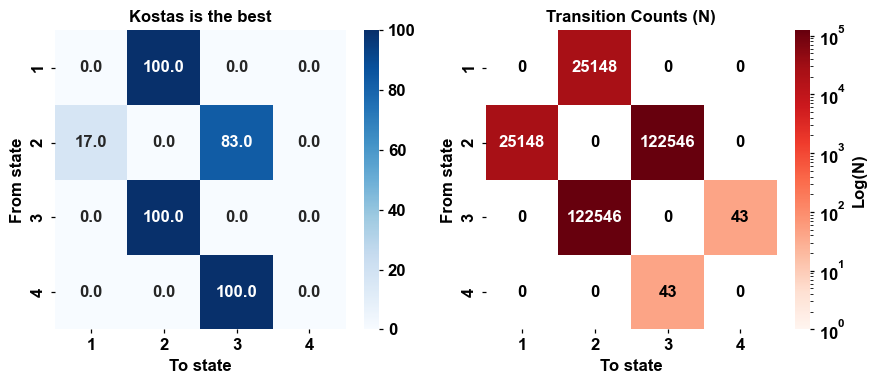

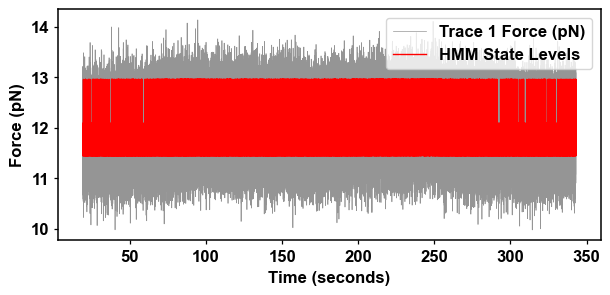

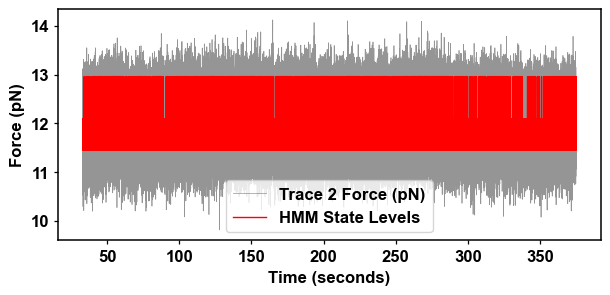

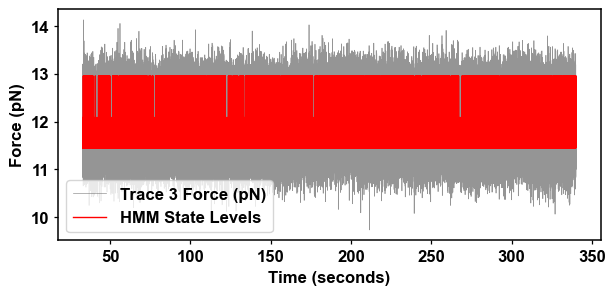

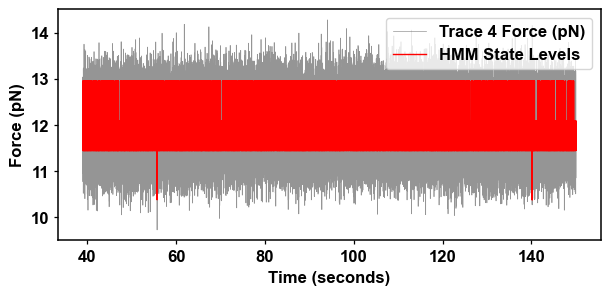

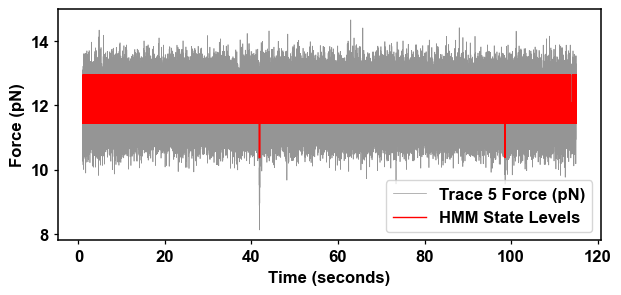

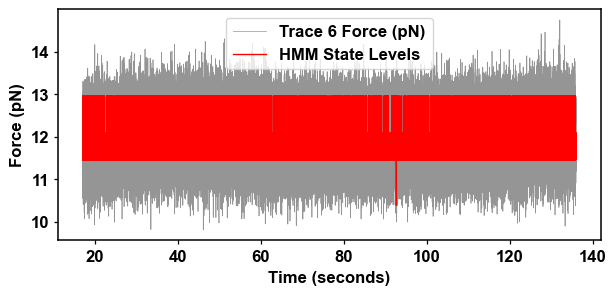

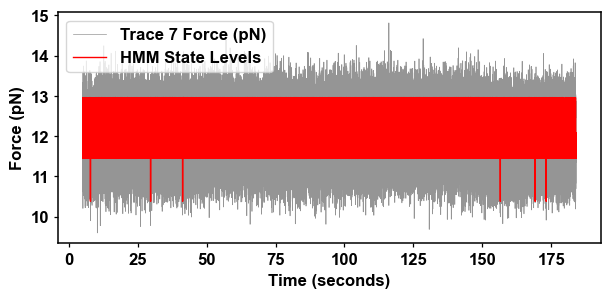

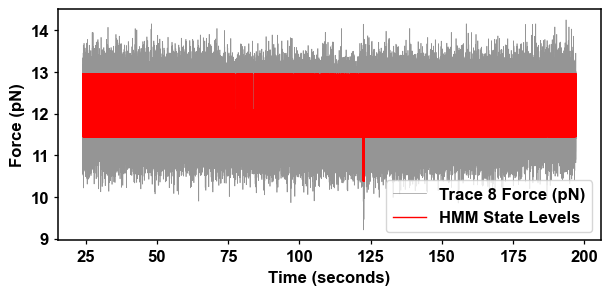

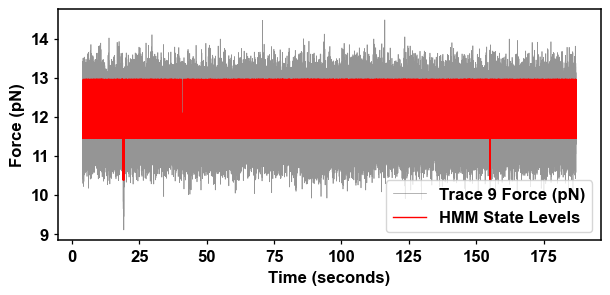

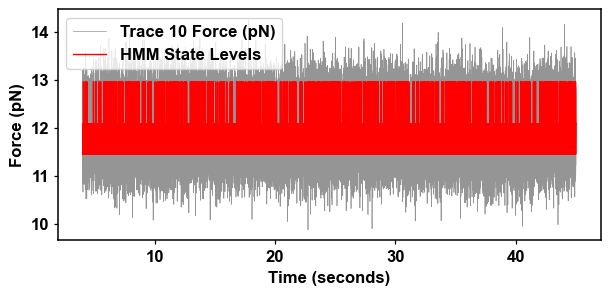

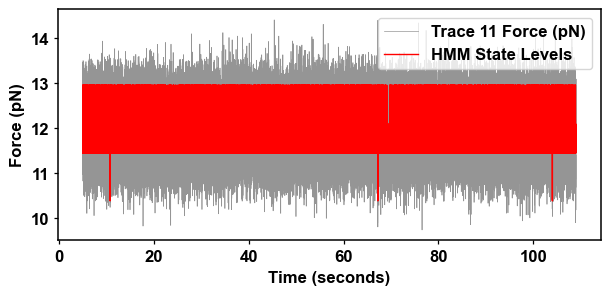

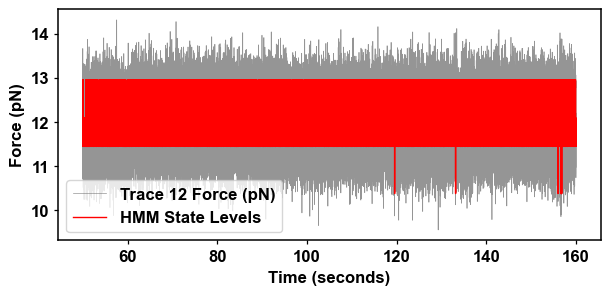

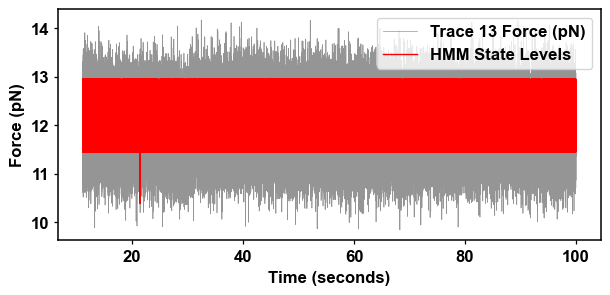

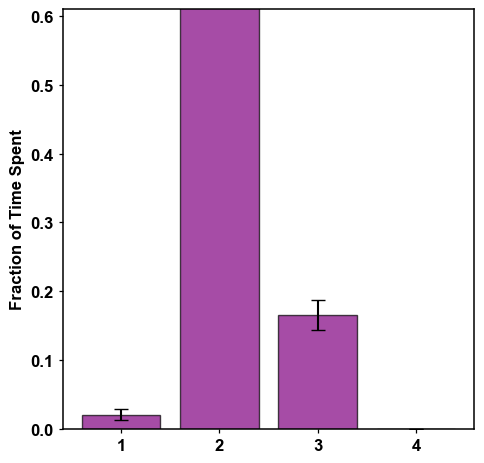

Mean fraction of time spent in each state: [2.08502123e-02 8.13371358e-01 1.65595461e-01 1.82969417e-04]
Standard deviation of time spent in each state: [0.00746366 0.0296227  0.02215428 0.00037648]


In [ ]:
c_hmm_results = HMM_predict_force([c1, c2, c3, c4, c5, c7, c8, c9, c10, c11, c12, c13, c14], "consensus_nterm_ctcfwt_4_model.pkl")
c_sorted_hs = plot_transition_and_HMM_force(c_hmm_results, [c1, c2, c3, c4, c5, c7, c8, c9, c10, c11, c12, c13, c14], 4, '/publication.pdf')

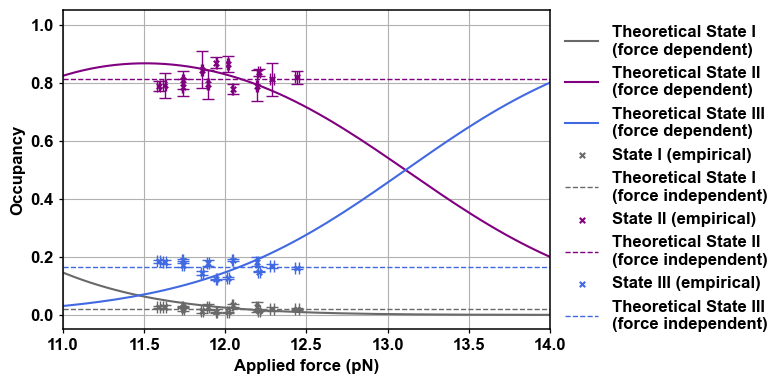

Baseline Energy Difference (Delta_G_12_0): 72.95 pN·nm
Baseline Energy Difference (Delta_G_23_0): 83.81 pN·nm


In [ ]:
force_state2 = 12.75
force_state4 = 11.35

weighted_occ_dna = [cd_hmm_result1[5]['State 0']*force_state2 + cd_hmm_result1[5]['State 1']*force_state4,
             cd_hmm_result2[5]['State 0']*force_state2 + cd_hmm_result2[5]['State 1']*force_state4,
             cd_hmm_result3[5]['State 0']*force_state2 + cd_hmm_result3[5]['State 1']*force_state4,
             cd_hmm_result5[5]['State 0']*force_state2 + cd_hmm_result5[5]['State 1']*force_state4,
             cd_hmm_result7[5]['State 0']*force_state2 + cd_hmm_result7[5]['State 1']*force_state4,
             cd_hmm_result8[5]['State 0']*force_state2 + cd_hmm_result8[5]['State 1']*force_state4,
             cd_hmm_result9[5]['State 0']*force_state2 + cd_hmm_result9[5]['State 1']*force_state4,
             cd_hmm_result10[5]['State 0']*force_state2 + cd_hmm_result10[5]['State 1']*force_state4,
             cd_hmm_result11[5]['State 0']*force_state2 + cd_hmm_result11[5]['State 1']*force_state4,
             cd_hmm_result12[5]['State 0']*force_state2 + cd_hmm_result12[5]['State 1']*force_state4,
             cd_hmm_result13[5]['State 0']*force_state2 + cd_hmm_result13[5]['State 1']*force_state4,
             cd_hmm_result14[5]['State 0']*force_state2 + cd_hmm_result14[5]['State 1']*force_state4,
             cd_hmm_result4[5]['State 0']*force_state2 + cd_hmm_result4[5]['State 1']*force_state4]

ctcf_occ_1 = [c_hmm_result1[5]['State 0'],
             c_hmm_result2[5]['State 0'],
             c_hmm_result3[5]['State 0'],
             c_hmm_result5[5]['State 0'],
             c_hmm_result7[5]['State 0'],
             c_hmm_result8[5]['State 0'],
             c_hmm_result9[5]['State 0'],
             c_hmm_result10[5]['State 0'],
             c_hmm_result11[5]['State 0'],
             c_hmm_result12[5]['State 0'],
             c_hmm_result13[5]['State 0'],
             c_hmm_result14[5]['State 0'],
             c_hmm_result4[5]['State 0']]

ctcf_occ_2 = [c_hmm_result1[5]['State 1'],
             c_hmm_result2[5]['State 1'],
             c_hmm_result3[5]['State 1'],
             c_hmm_result5[5]['State 1'],
             c_hmm_result7[5]['State 1'],
             c_hmm_result8[5]['State 1'],
             c_hmm_result9[5]['State 1'],
             c_hmm_result10[5]['State 1'],
             c_hmm_result11[5]['State 1'],
             c_hmm_result12[5]['State 1'],
             c_hmm_result13[5]['State 1'],
             c_hmm_result14[5]['State 1'],
             c_hmm_result4[5]['State 1']]

ctcf_occ_3 = [c_hmm_result1[5]['State 2'],
             c_hmm_result2[5]['State 2'],
             c_hmm_result3[5]['State 2'],
             c_hmm_result5[5]['State 2'],
             c_hmm_result7[5]['State 2'],
             c_hmm_result8[5]['State 2'],
             c_hmm_result9[5]['State 2'],
             c_hmm_result10[5]['State 2'],
             c_hmm_result11[5]['State 2'],
             c_hmm_result12[5]['State 2'],
             c_hmm_result13[5]['State 2'],
             c_hmm_result14[5]['State 2'],
             c_hmm_result4[5]['State 2']]

# Constants
k_B_T = 4.1  # pN·nm (Boltzmann constant times temperature)
x_12 = 0.68 * np.abs(-12.7-(-2.0))  # nm (distance between state 1 and state 2)
x_23 = 0.68 * np.abs(-2.0-7.4)  # nm (distance between state 2 and state 3)
force = 12.09 # pN (example force value at which occupancies are known)

occs = [2.08502123e-02, 8.13371358e-01, 1.65595461e-01, 1.82969417e-04]

# Known occupancies at 12 pN
P_1_12 = occs[0] / (occs[0] + occs[1] + occs[2])
P_2_12 = occs[1] / (occs[0] + occs[1] + occs[2])
P_3_12 = occs[2] / (occs[0] + occs[1] + occs[2])

# Calculate energy differences at 12 pN
Delta_G_12_12 = -k_B_T * np.log(P_2_12 / P_1_12)  # Energy difference between states 1 and 2 at 12 pN
Delta_G_23_12 = -k_B_T * np.log(P_3_12 / P_2_12)  # Energy difference between states 2 and 3 at 12 pN

# Calculate baseline energy differences (at zero force)
Delta_G_12_0 = Delta_G_12_12 + force * x_12
Delta_G_23_0 = Delta_G_23_12 + force * x_23

# Generate a range of forces (0 to 25 pN)
forces = np.linspace(0, 25, 500)

# Free energy differences with force
Delta_G_12_F = Delta_G_12_0 - forces * x_12
Delta_G_23_F = Delta_G_23_0 - forces * x_23

# Calculate state probabilities
exp_12 = np.exp(-Delta_G_12_F / k_B_T)
exp_23 = np.exp(-(Delta_G_12_F + Delta_G_23_F) / k_B_T)

P_1 = 1 / (1 + exp_12 + exp_23)
P_2 = exp_12 / (1 + exp_12 + exp_23)
P_3 = exp_23 / (1 + exp_12 + exp_23)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(forces, P_1, label="Theoretical State I\n(force dependent)", color="dimgrey")
plt.plot(forces, P_2, label="Theoretical State II\n(force dependent)", color="purple")
plt.plot(forces, P_3, label="Theoretical State III\n(force dependent)", color="royalblue")

plt.errorbar(
    weighted_occ_dna,  # x values
    ctcf_occ_1,        # y values
    xerr=dna_ste,          # x error
    yerr=state_se_lists['State 0'],
    fmt='none',        # No marker for the error bars
    ecolor='dimgrey',      # Error bar color
    elinewidth=1,      # Error bar line width
    capsize=4)         # Size of error bar caps
plt.scatter(weighted_occ_dna, ctcf_occ_1, marker='x', s=15, color='dimgrey', label='State I (empirical)')
plt.axhline(y = occs[0], linestyle = '--', lw=1, color='dimgrey', label = 'Theoretical State I\n(force independent)')

plt.errorbar(
    weighted_occ_dna,  # x values
    ctcf_occ_2,        # y values
    xerr=dna_ste,          # x error
    yerr=state_se_lists['State 2'],
    fmt='none',        # No marker for the error bars
    ecolor='purple',      # Error bar color
    elinewidth=1,      # Error bar line width
    capsize=4)         # Size of error bar caps
plt.scatter(weighted_occ_dna, ctcf_occ_2, marker='x', s=15, color='purple', label='State II (empirical)')
plt.axhline(y = occs[1], linestyle = '--', lw=1, color='purple', label = 'Theoretical State II\n(force independent)')

plt.errorbar(
    weighted_occ_dna,  # x values
    ctcf_occ_3,        # y values
    xerr=dna_ste,          # x error
    yerr=state_se_lists['State 0'],
    fmt='none',        # No marker for the error bars
    ecolor='royalblue',      # Error bar color
    elinewidth=1,      # Error bar line width
    capsize=4)         # Size of error bar caps
plt.scatter(weighted_occ_dna, ctcf_occ_3, marker='x', s=15, color='royalblue', label='State III (empirical)')
plt.axhline(y = occs[2], linestyle = '--', lw=1, color='royalblue', label = 'Theoretical State III\n(force independent)')
plt.xlabel("Applied force (pN)")
plt.ylabel("Occupancy")
#plt.title("Occupancy of States vs Applied Force (3 States)")
plt.grid(True)
plt.xlim(11,14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.tight_layout()
plt.savefig('/publication.pdf', format='pdf')
plt.show()

# Print calculated baseline energies
print(f"Baseline Energy Difference (Delta_G_12_0): {Delta_G_12_0:.2f} pN·nm")
print(f"Baseline Energy Difference (Delta_G_23_0): {Delta_G_23_0:.2f} pN·nm")


In [79]:
import numpy as np
from scipy.stats import chi2

# Observed data (example)
x_obs = np.array(weighted_occ_dna)  # Observed forces
y_obs = np.array(ctcf_occ_1)  # Observed occupancies for State I
sigma_x = np.array(dna_ste)  # x-direction errors
sigma_y_data = np.array(state_se_lists['State 0'])  # y-direction errors

# Theoretical model for State I (interpolate for observed forces)
def theoretical_model(F):
    exp_12 = np.exp(-(Delta_G_12_0 - F * x_12) / k_B_T)
    exp_23 = np.exp(-(Delta_G_12_0 - F * x_12 + Delta_G_23_0 - F * x_23) / k_B_T)
    return 1 / (1 + exp_12 + exp_23)

y_model = theoretical_model(x_obs)

# Derivative of theoretical model for error propagation
def model_derivative(F):
    exp_12 = np.exp(-(Delta_G_12_0 - F * x_12) / k_B_T)
    exp_23 = np.exp(-(Delta_G_12_0 - F * x_12 + Delta_G_23_0 - F * x_23) / k_B_T)
    denom = (1 + exp_12 + exp_23) ** 2
    dP_dF = (-x_12 * exp_12 - (x_12 + x_23) * exp_23) / (k_B_T * denom)
    return dP_dF

sigma_combined = np.sqrt(
    sigma_y_data**2 + (model_derivative(x_obs) * sigma_x) ** 2
)

# Chi-square statistic
chi_square = np.sum(((y_obs - y_model) / sigma_combined) ** 2)

# Degrees of freedom
dof = len(x_obs) - 2  # Number of data points minus number of fitted parameters

# p-value
p_value = 1 - chi2.cdf(chi_square, dof)

# Output results
print(f"Chi-square statistic: {chi_square:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p_value:.3f}")

if p_value > 0.05:
    print("The data is consistent with the theoretical model.")
else:
    print("The data significantly deviates from the theoretical model.")


Chi-square statistic: 238.36
Degrees of freedom: 11
p-value: 0.000
The data significantly deviates from the theoretical model.


In [80]:
import numpy as np
from scipy.stats import chi2

# Observed data
y_obs = np.array(ctcf_occ_1)  # Observed y values for State I
y_model = 2.08502123e-02  # Theoretical constant model
sigma_y_data = np.array(state_se_lists['State 0'])  # y-direction errors

# Chi-square statistic
chi_square = np.sum(((y_obs - y_model) / sigma_y_data) ** 2)

# Degrees of freedom
dof = len(y_obs) - 1  # One parameter (the constant value)

# P-value
p_value = 1 - chi2.cdf(chi_square, dof)

# Output results
print(f"Chi-square statistic: {chi_square:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value:.3f}")

if p_value > 0.05:
    print("The data is consistent with the theoretical model (y = 12.18).")
else:
    print("The data significantly deviates from the theoretical model (y = 12.18).")


Chi-square statistic: 85.44
Degrees of freedom: 12
P-value: 0.000
The data significantly deviates from the theoretical model (y = 12.18).


In [81]:
import numpy as np

# Observed data
y_obs = np.array(ctcf_occ_1)  # Observed occupancies for State I
sigma_y_data = np.array(state_se_lists['State 0'])  # y-direction errors

# Convert weighted_occ_dna to a numpy array
weighted_occ_dna = np.array(weighted_occ_dna)

# Constants
k_B_T = 4.1  # pN·nm (Boltzmann constant times temperature)
x_12 = 0.68 * np.abs(-12.7 - (-2.0))  # nm (distance between state 1 and state 2)
x_23 = 0.68 * np.abs(-2.0 - 7.4)  # nm (distance between state 2 and state 3)

# Calculate energy differences at 12 pN
Delta_G_12_0 = -k_B_T * np.log(P_2_12 / P_1_12)  # Energy difference between states 1 and 2 at 12 pN
Delta_G_23_0 = -k_B_T * np.log(P_3_12 / P_2_12)  # Energy difference between states 2 and 3 at 12 pN

# Original model function
def original_model(F):
    exp_12 = np.exp(-(Delta_G_12_0 - F * x_12) / k_B_T)
    exp_23 = np.exp(-(Delta_G_12_0 - F * x_12 + Delta_G_23_0 - F * x_23) / k_B_T)
    return 1 / (1 + exp_12 + exp_23)

# Theoretical values
y_model_original = original_model(weighted_occ_dna)
y_model_constant = np.full_like(y_obs, 2.08502123e-02)

# Log-likelihood calculation
def log_likelihood(y_obs, y_model, sigma_y):
    return -0.5 * np.sum(((y_obs - y_model) / sigma_y) ** 2 + np.log(2 * np.pi * sigma_y ** 2))

log_L_original = log_likelihood(y_obs, y_model_original, sigma_y_data)
log_L_constant = log_likelihood(y_obs, y_model_constant, sigma_y_data)

# Number of parameters
k_original = 2  # Number of parameters in the original model
k_constant = 1  # Number of parameters in the constant model

# AIC calculation
AIC_original = 2 * k_original - 2 * log_L_original
AIC_constant = 2 * k_constant - 2 * log_L_constant

# BIC calculation
n = len(y_obs)
BIC_original = k_original * np.log(n) - 2 * log_L_original
BIC_constant = k_constant * np.log(n) - 2 * log_L_constant

# Output results
print(f"AIC (Original Model): {AIC_original:.2f}")
print(f"AIC (Constant Model): {AIC_constant:.2f}")
print(f"BIC (Original Model): {BIC_original:.2f}")
print(f"BIC (Constant Model): {BIC_constant:.2f}")

if AIC_original < AIC_constant:
    print("The original model is preferred based on AIC.")
else:
    print("The constant model is preferred based on AIC.")

if BIC_original < BIC_constant:
    print("The original model is preferred based on BIC.")
else:
    print("The constant model is preferred based on BIC.")


AIC (Original Model): 165.24
AIC (Constant Model): -26.04
BIC (Original Model): 166.37
BIC (Constant Model): -25.47
The constant model is preferred based on AIC.
The constant model is preferred based on BIC.


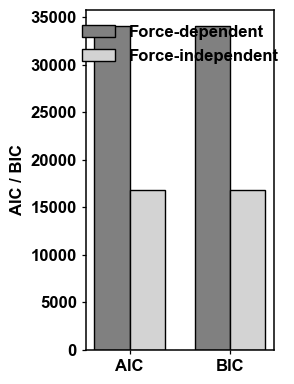

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
dep = [34051.23, 34053.49]
ind = [16874.56, 16875.12]


# Labels for the bars
labels = ['AIC', 'BIC']

# Bar width
width = 0.35

# Bar positions
x = np.arange(len(labels))

# Create the figure and axes
plt.figure(figsize=(3, 4))

# Plot the 'dep' bars
plt.bar(x - width/2, dep, width=width, label='Force-dependent', color='grey', edgecolor='black')

# Plot the 'ind' bars
plt.bar(x + width/2, ind, width=width, label='Force-independent', color='lightgrey', edgecolor='black')

# Add labels, title, and legend
plt.xticks(x, labels)
plt.ylabel('AIC / BIC')
#plt.yticks([])
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Add a horizontal line at y=0
plt.legend(loc='upper center', frameon=False)
plt.tight_layout()
plt.savefig('/publication.pdf', format='pdf')
# Show the plot
plt.show()


In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Observed data
y_obs_1 = np.array(ctcf_occ_1)  # Observed occupancies for State I
y_obs_2 = np.array(ctcf_occ_2)  # Observed occupancies for State II
y_obs_3 = np.array(ctcf_occ_3)  # Observed occupancies for State III

sigma_y_1 = np.array(state_se_lists['State 0'])  # Errors for State I
sigma_y_2 = np.array(state_se_lists['State 1'])  # Errors for State II
sigma_y_3 = np.array(state_se_lists['State 2'])  # Errors for State III

# Convert weighted_occ_dna to a numpy array
weighted_occ_dna = np.array(weighted_occ_dna)

# Constants
k_B_T = 4.1  # pN·nm (Boltzmann constant times temperature)
x_12 = 0.68 * np.abs(-12.7 - (-2.0))  # nm (distance between state 1 and state 2)
x_23 = 0.68 * np.abs(-2.0 - 7.4)  # nm (distance between state 2 and state 3)

# Calculate energy differences at 12 pN
Delta_G_12_0 = -k_B_T * np.log(P_2_12 / P_1_12)  # Energy difference between states 1 and 2 at 12 pN
Delta_G_23_0 = -k_B_T * np.log(P_3_12 / P_2_12)  # Energy difference between states 2 and 3 at 12 pN

# Original model function
def original_model(F):
    exp_12 = np.exp(-(Delta_G_12_0 - F * x_12) / k_B_T)
    exp_23 = np.exp(-(Delta_G_12_0 - F * x_12 + Delta_G_23_0 - F * x_23) / k_B_T)
    P_1 = 1 / (1 + exp_12 + exp_23)
    P_2 = exp_12 / (1 + exp_12 + exp_23)
    P_3 = exp_23 / (1 + exp_12 + exp_23)
    return P_1, P_2, P_3

# Theoretical values
y_model_1, y_model_2, y_model_3 = original_model(weighted_occ_dna)
y_model_constant = np.full_like(y_obs_1, 2.08502123e-02)  # Constant model as an example

# Log-likelihood calculation
def log_likelihood(y_obs_1, y_model_1, sigma_y_1,
                   y_obs_2, y_model_2, sigma_y_2,
                   y_obs_3, y_model_3, sigma_y_3):
    ll_1 = -0.5 * np.sum(((y_obs_1 - y_model_1) / sigma_y_1) ** 2 + np.log(2 * np.pi * sigma_y_1 ** 2))
    ll_2 = -0.5 * np.sum(((y_obs_2 - y_model_2) / sigma_y_2) ** 2 + np.log(2 * np.pi * sigma_y_2 ** 2))
    ll_3 = -0.5 * np.sum(((y_obs_3 - y_model_3) / sigma_y_3) ** 2 + np.log(2 * np.pi * sigma_y_3 ** 2))
    return ll_1 + ll_2 + ll_3

log_L_original = log_likelihood(y_obs_1, y_model_1, sigma_y_1,
                                 y_obs_2, y_model_2, sigma_y_2,
                                 y_obs_3, y_model_3, sigma_y_3)
log_L_constant = log_likelihood(y_obs_1, y_model_constant, sigma_y_1,
                                 y_obs_2, y_model_constant, sigma_y_2,
                                 y_obs_3, y_model_constant, sigma_y_3)

# Number of parameters
k_original = 4  # Two energy differences (Delta_G_12_0, Delta_G_23_0) and two x-distances (x_12, x_23)
k_constant = 1  # The constant model has only one parameter

# AIC calculation
AIC_original = 2 * k_original - 2 * log_L_original
AIC_constant = 2 * k_constant - 2 * log_L_constant

# BIC calculation
n = len(y_obs_1)  # Number of data points (same for all states)
BIC_original = k_original * np.log(n) - 2 * log_L_original
BIC_constant = k_constant * np.log(n) - 2 * log_L_constant

# Output results
print(f"AIC (Original Model): {AIC_original:.2f}")
print(f"AIC (Constant Model): {AIC_constant:.2f}")
print(f"BIC (Original Model): {BIC_original:.2f}")
print(f"BIC (Constant Model): {BIC_constant:.2f}")

if AIC_original < AIC_constant:
    print("The original model is preferred based on AIC.")
else:
    print("The constant model is preferred based on AIC.")

if BIC_original < BIC_constant:
    print("The original model is preferred based on BIC.")
else:
    print("The constant model is preferred based on BIC.")


AIC (Original Model): 34051.23
AIC (Constant Model): 16874.56
BIC (Original Model): 34053.49
BIC (Constant Model): 16875.12
The constant model is preferred based on AIC.
The constant model is preferred based on BIC.
